# Cournot model
**For N heterogenous firms that produce heterogenous goods**

# Introduction:

**The aim of this paper is to develop an algorithm to simulate the strategic interaction of firms in the Cournot model.**

The Cournot model describes oligopoly markets where the firms produce homogeneous products and maximize profits by engaging in strategic interaction. The choice variable is quantities, which firms set simultaneously, the sum of these equate total supply, which determines the market price in the model. We find the Nash Equilibrium, where no firm want not change its quantity in response to the output of others. Furthermore, the firms are considered to have complete information about the market and the actions of its competitors. Given the features of the Cournot model this paper has particular emphasis on firm behavior with various degrees of competition, different cost levels between the firms and when the firms produce heterogenous goods that are not perfect substitutes.


**Model equations**

Each firm have a profit function given by: $\Pi_i(x_i,c_i,b)=p_i \cdot x_i-c_i \cdot x_i$, where $p_i$ is the price for the firm's goods, $c_i$ is the firm's marginal costs and $x_i$ is firm's i production quantity, $b$ is the degree of homogenity of firm i's goods relative to the rest of the market and $b\in[0,1]$.

Firms have individual marginal cost $c_i=0.01 \cdot exp(x_i)$ where $x_i$~$N(0,1)$

The price of firm i's goods are given by: $p_i=1-x_i-b \cdot x_{rest_{i}}$, where $x_{rest}$ denotes the total output for all other firms in the market. The price is thereby normalized to 1. 

Each firm maximize profits: $\max\Pi_i(x_i,c_i,b) $ st. $x_i \in [0,1]$.

Note that each firm'a goods have the same price in equilibrium when $b$=1 which is used as the benchmark case.

# Model description

The **first step** is to define the profit function analytically using *sympy*. The profit depend on each firm's own production, what the rest of the firms produce, the degree of substitution between the firms product and the rest of the market and its marginal cost. We then take the first order partial derivate wrt. each firms own level of production. Setting the partial derivatives to zero (first order condition) yields N best-response functions. The market equilibrium is a Nash Equilibrium where all first play best responses simultaneously. Before moving on, we take partial derivatives wrt. both own production and the rest of the market's production such that we can use *optimize.root* to find the solution. We then lambdify the expressions.

In a **second step** we use the functions we just lambdified to create the $N$ equations for the best-responses and the $N^2$ equations second order derivates of the profit function (the Jacobian Matrix for use in optimization).

In a **third step** we draw random marginal costs from a log-normal distribution, which creates heterogeniety in the production functions. We then solve the system of equations using *optimize.root*. For sufficiently large marginal costs relative to the number of firms, some firms will choose to produce a negative quantity. Because *optimize.root* cannot handle constraints we implement an algoritm whereby we remove the firms with producing negative quantities and reestimate the model. We do so continuosly until there are no firms that choose a negative quantity.

**Imports and set magics:**

In [8]:
# Import modules
import numpy as np
import sympy as sm

from scipy.stats import norm
from numpy import array
import matplotlib.pyplot as plt
import plotly.graph_objs as go

# Graphs inline
%matplotlib inline

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Module with project specific functions
import modelproject

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
# Defining symbolic variables
p      = sm.symbols('p')   # price
c      = sm.symbols('c')   # marginal cost
b      = sm.symbols('b')   # degree of substitution between products (range = 0-1)
x      = sm.symbols('x')   # Symbolic variable representing x
x_rest = sm.symbols('X_r') # Symbolic variable representing x_rest

# Define equations and functions

eq_price    = sm.Eq(p, 1-x-b*x_rest)     # demand (inverse demand function)
func_profit = p * x - c * x              # firm profit

p_from_pricefun = sm.solve(eq_price, p)  # isolate price as a variable

objective = func_profit.subs(p,p_from_pricefun[0]) # substitute price into profit to get objective

# 1st order derivative of profit wrt. x to get FOC for profit max
objective_diff_self = sm.diff(objective, x)

# 2nd order derivative of profit wrt. x and x_rest to get Jacobian Matrix
bestresponse_diff_self = sm.diff(objective_diff_self, x)
bestresponse_diff_rest = sm.diff(objective_diff_self, x_rest)

-c*x + x*(-X_r*b - x + 1)

The profit function for each firm is given by:


In [34]:
objective

-c*x + x*(-X_r*b - x + 1)

The best-response function is thus given by:


In [35]:
objective_diff_self

-X_r*b - c - 2*x + 1

**Plot of firm marginal cost, firm output and firm profit**

The plot below shows the relationship between costs, produced amounts and profits for 150 firms that can produce. From the plot it is evident that as costs increase, the amounts produced by the firms decrease and so does profits. These results coincide with economic theory and the properties of the Cournot model as an increased cost base for the firms renders production less profitable and leads to a lower output and subsequently lower profits. It can also be seen that firms with marginal costs over some level choose not to produce, because they produce to inefficiently.

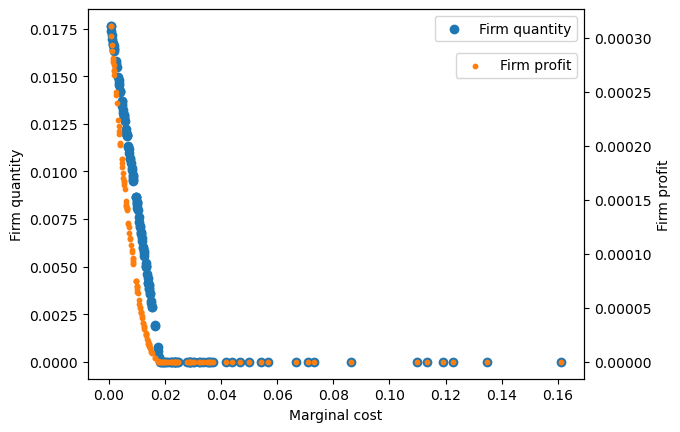

In [22]:
#Run the model for 150 firms
sol = modelproject.solve_model(150, display=False)

# Define the x, y1, and y2 data
x = sol.c_vec_init
y1 = sol.x0
y2 = sol.profit

# Create a figure and axis object
fig, ax1 = plt.subplots()

# Plot x0 on the first y-axis
ax1.set_xlabel('Marginal cost')
ax1.set_ylabel('Firm quantity')
ax1.scatter(x, y1, color='tab:blue', label='Firm quantity')

# Create a second y-axis object
ax2 = ax1.twinx()

# Plot profit on the second y-axis
ax2.set_ylabel('Firm profit')
ax2.scatter(x, y2, color='tab:orange', label='Firm profit', s=10)

# Add a legend in the upper right corner
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

**Plot of number of firms, market quantity and total market profit**

The following plot shows how the total produced amount in an market and mean industry profits change with increased competition. As evident from the figure, a higher degree of competition increases the total amount produced in the market. Furthermore, the market supply converges towards the standardized potential total supply in the Cournot model, which is 1, whereas profits converge towards 0 as the number of firms increase.

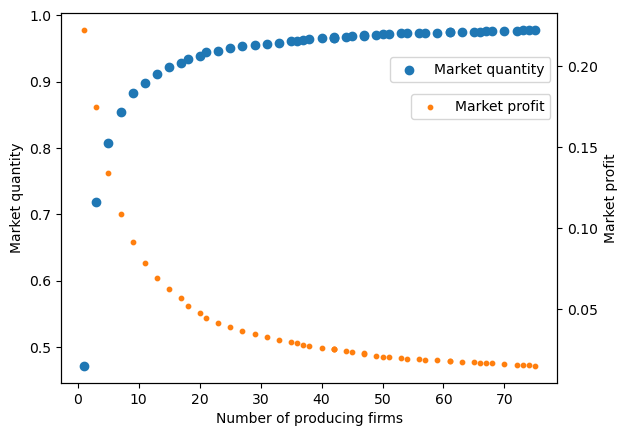

In [11]:
#Create lists to save the results in
N_init_list = range(1,100,2)
N_list = []
x_list = []
profit_list = []

#Run model
for i in N_init_list: 
    sol = modelproject.solve_model(i,display=False)
    sum_profit = sum(sol.profit)
    sum_x = sum(sol.x0)
    profit_list.append(sum_profit)
    x_list.append(sum_x)
    N_list.append(sol.N)

# Create a figure and axis object
fig, ax1 = plt.subplots()

# Plot x0 on the first y-axis
ax1.set_xlabel('Number of producing firms')
ax1.set_ylabel('Market quantity')
ax1.scatter(N_list, x_list, color='tab:blue', label='Market quantity')

# Create a second y-axis object
ax2 = ax1.twinx()

# Plot profit on the second y-axis
ax2.set_ylabel('Market profit')
ax2.scatter(N_list, profit_list, color='tab:orange', label='Market profit',s=10)

# Add a legend in the upper right corner
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.8))
ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

# Show the plot
plt.show()

**Plot of degree of product homogenity, market quantity and market profits in a 20 firm market with not marginal costs**

The plot shows the product homogenity of the products in a market where 1 denotes complete product homogenity in the market, and 0 denotes completely heterogenous goods. From the plot it is evident, that as the degree of product homogenity increases the firms in the market experience a higher degree of competitive pressure and hence produce fewer products and obtain lower profits. In the limit, when goods are completely heterogenous 20 firms produce 10 goods, which is 0.5 per firm. This shows that firms behave as monopolits, because 0.5 is the optimal quantity in this model in a market with 1 firm (monopoly).

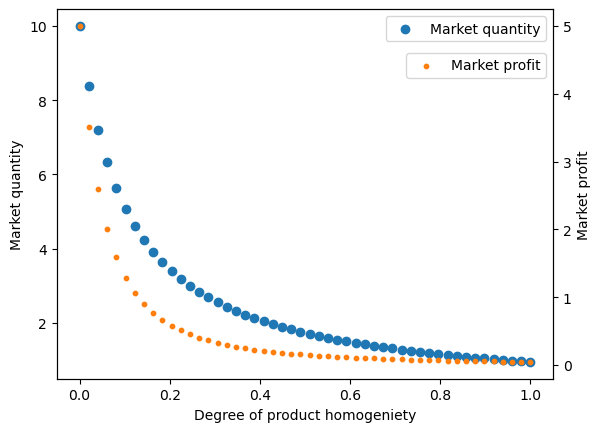

In [12]:
b_list = np.linspace(0,1,50)
x_list = []
profit_list = []

#Run model for 20 firms
for i in b_list: 
    sol = modelproject.solve_model(20,b=i,c_constant=0,display=False)
    sum_profit = sum(sol.profit)
    sum_x = sum(sol.x0)
    profit_list.append(sum_profit)
    x_list.append(sum_x)

# Create a figure and axis object
fig, ax1 = plt.subplots()

# Plot x0 on the first y-axis
ax1.set_xlabel('Degree of product homogeniety')
ax1.set_ylabel('Market quantity')
ax1.scatter(b_list, x_list, color='tab:blue', label='Market quantity')

# Create a second y-axis object
ax2 = ax1.twinx()

# Plot profit on the second y-axis
ax2.set_ylabel('Market profit')
ax2.scatter(b_list, profit_list, color='tab:orange', label='Market profit', s=10)

# Add a legend in the upper right corner
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

**Plot of potential number of firms, average marginal costs and the number of producing firms**

The plot shows that when competition (number of firms that can produce) increases, the average marginal costs for the producing firms goes towards 0. In other words, it leads to a competitive environment where inefficient firms exit the market due to too high marginal costs of production.

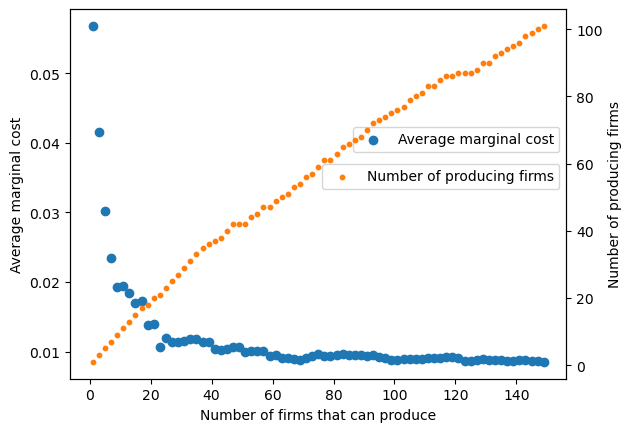

In [13]:
N_init_list = range(1,150,2)
c_list = []
N_list = []

for i in N_init_list: 
    sol = modelproject.solve_model(i,display=False)
    mean_c = np.mean(sol.c_vec)
    c_list.append(mean_c)
    N_list.append(sol.N)

# Create a figure and axis object
fig, ax1 = plt.subplots()

# Plot x0 on the first y-axis
ax1.set_xlabel('Number of firms that can produce')
ax1.set_ylabel('Average marginal cost')
ax1.scatter(N_init_list, c_list, color='tab:blue', label='Average marginal cost')

# Create a second y-axis object
ax2 = ax1.twinx()

# Plot profit on the second y-axis
ax2.set_ylabel('Number of producing firms')
ax2.scatter(N_init_list, N_list, color='tab:orange', label='Number of producing firms', s=10)

# Add a legend in the upper right corner
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.6))
ax1.legend(loc='upper right', bbox_to_anchor=(1, 0.7))

# Show the plot
plt.show()

# Conclusion

We are succesfully able to replicate the analytical findings in the canonical Cournot model with mulitple homogenous firms. We extend the model to allow for heterogenous firms, who face different marginal costs, and produce non-homogenous goods.

We find that:
- Firm profits and firm output decreases as marginal cost increase and that firms with larger marginal cost exit the market.
- Market quantity converges towards perfect competition levels as the number of firms increase while market profits converge towards 0.
- As product homogeniety increases, market quantity decreases, and when $b$=1 there are no longer N separate (overlapping) demand curves. As homogenity increases market profit decreases due to larger competition.
- When the number of firms that can produce increases firms with larger marginal costs are to an increasing extend pushed out of the market, such that average marginal costs for the remaining firms in the market converge towards 0.